In [111]:
FILE_NAME = "0_130000_ciaran_donuts.csv"

In [112]:
import pandas as pd

df = pd.read_csv(FILE_NAME)

In [113]:
STEERING_ANGLE_COLUMN = 'Analog5|"Volts"|0.0|5.0|500'
TIME_COLUMN = 'Interval|"ms"|0|0|1'
REAR_AXLE_COLUMN = 'RPM|"rpm"|0|8000|500'
YAW_COLUMN = 'Yaw|"Deg/Sec"|-120|120|200'
TIRE_RADIUS = 0.2921 # meters
TIRE_CIRCUMFERENCE = 2*TIRE_RADIUS * 3.14159 # meters


In [114]:
steering_angle = (df[STEERING_ANGLE_COLUMN] -1.8)*10 #this is for testing because I don't have the steering angle column
times = df[TIME_COLUMN]

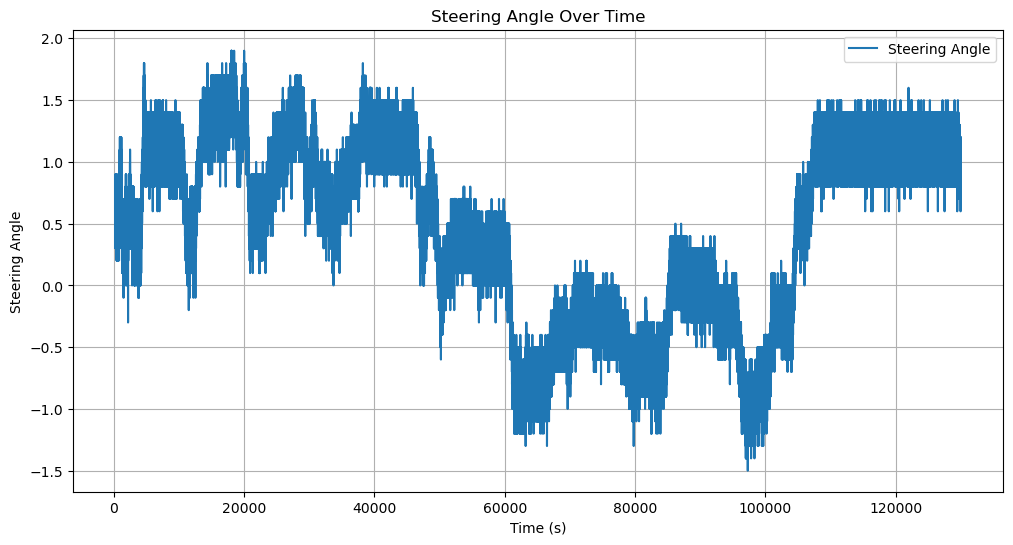

In [115]:
import matplotlib.pyplot as plt

valid_mask = ~steering_angle.isna()

plt.figure(figsize=(12, 6))
plt.plot(times[valid_mask], steering_angle[valid_mask], label='Steering Angle')
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Time')
plt.legend()
plt.grid()
plt.show()


c:\Users\Frank\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


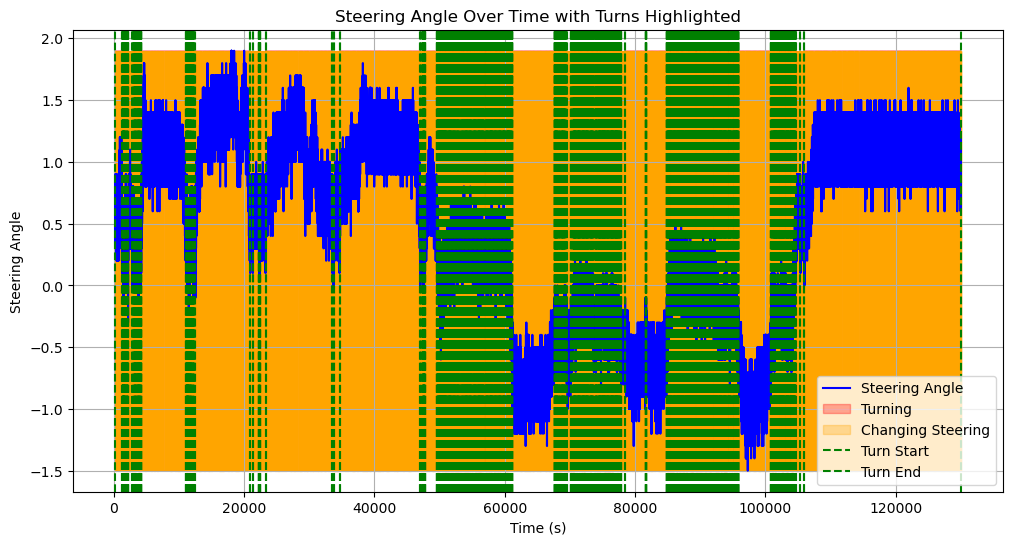

Detected turning intervals (by index):
Start Index: 0, End Index: 540
Start Index: 541, End Index: 561
Start Index: 562, End Index: 571
Start Index: 572, End Index: 575
Start Index: 576, End Index: 580
Start Index: 581, End Index: 585
Start Index: 586, End Index: 590
Start Index: 591, End Index: 601
Start Index: 602, End Index: 610
Start Index: 611, End Index: 616
Start Index: 617, End Index: 621
Start Index: 623, End Index: 626
Start Index: 627, End Index: 629
Start Index: 630, End Index: 633
Start Index: 634, End Index: 636
Start Index: 637, End Index: 641
Start Index: 642, End Index: 648
Start Index: 649, End Index: 656
Start Index: 657, End Index: 662
Start Index: 663, End Index: 668
Start Index: 669, End Index: 675
Start Index: 676, End Index: 681
Start Index: 682, End Index: 688
Start Index: 689, End Index: 697
Start Index: 698, End Index: 703
Start Index: 704, End Index: 705
Start Index: 706, End Index: 710
Start Index: 712, End Index: 716
Start Index: 717, End Index: 721
Start 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

valid_mask = ~steering_angle.isna()
times_clean = times[valid_mask].reset_index(drop=True)
steering_angle_clean = steering_angle[valid_mask].reset_index(drop=True)

############################################################ I think it is assuming radians. I will to change it to do in degrees
# Settings
STEERING_THRESHOLD = 0.2   # Threshold for being "in a turn" (adjust if needed)
DELTA_THRESHOLD = 0.05     # Threshold for steering rate change (adjust if needed)

# Compute steering change per second
dt = np.diff(times_clean)               # time differences
dsteer = np.diff(steering_angle_clean)   # steering angle differences
steer_rate = dsteer / dt                 # rate of steering change

# Detect conditions
is_turning = np.abs(steering_angle_clean) > STEERING_THRESHOLD
is_changing = np.abs(steer_rate) > DELTA_THRESHOLD

# Pad steer_rate to match array length
is_changing = np.append(is_changing, False)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(times_clean, steering_angle_clean, label='Steering Angle', color='blue')

# Highlight turning regions
plt.fill_between(times_clean, steering_angle_clean.min(), steering_angle_clean.max(), where=is_turning, color='red', alpha=0.3, label='Turning')
plt.fill_between(times_clean, steering_angle_clean.min(), steering_angle_clean.max(), where=is_changing, color='orange', alpha=0.3, label='Changing Steering')

# Mark intervals with vertical lines
turning_intervals = find_intervals(is_turning)
for start, end in turning_intervals:
    plt.axvline(x=times_clean[start], color='green', linestyle='--', label='Turn Start' if start == turning_intervals[0][0] else "")
    plt.axvline(x=times_clean[end], color='green', linestyle='--', label='Turn End' if end == turning_intervals[-1][1] else "")

plt.xlabel('Time (s)')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Time with Turns Highlighted')
plt.legend()
plt.grid()
plt.show()

# ---------------------------
# Find and print turn intervals (using indices instead of time)
# ---------------------------

def find_intervals(mask):
    intervals = []
    in_interval = False
    start_index = None

    for i, val in enumerate(mask):
        if val and not in_interval:
            start_index = i
            in_interval = True
        elif not val and in_interval:
            end_index = i
            intervals.append((start_index, end_index))
            in_interval = False

    # If still in an interval at the end
    if in_interval:
        intervals.append((start_index, len(mask)-1))
    
    return intervals

turning_intervals = find_intervals(is_turning)

print("Detected turning intervals (by index):")
for start, end in turning_intervals:
    print(f"Start Index: {start}, End Index: {end}")


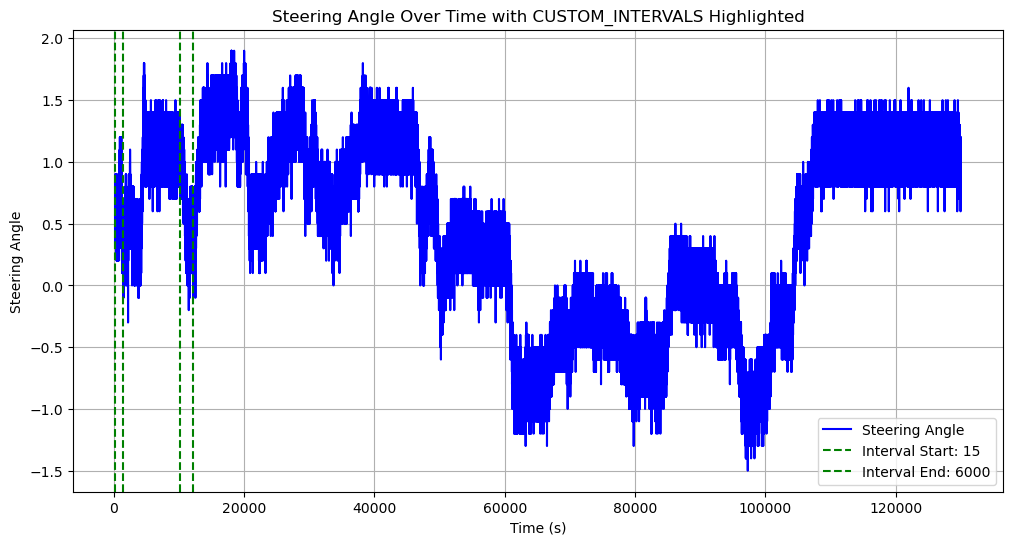

In [123]:
CUSTOM_INTERVALS = [(15, 610), (5000, 6000)]

# Plotting the custom intervals graph
plt.figure(figsize=(12, 6))
plt.plot(times_clean, steering_angle_clean, label='Steering Angle', color='blue')

# Highlight custom intervals with vertical lines
for start, end in CUSTOM_INTERVALS:
    plt.axvline(x=times_clean[start], color='green', linestyle='--', label=f'Interval Start: {start}' if start == CUSTOM_INTERVALS[0][0] else "")
    plt.axvline(x=times_clean[end], color='green', linestyle='--', label=f'Interval End: {end}' if end == CUSTOM_INTERVALS[-1][1] else "")

plt.xlabel('Time (s)')
plt.ylabel('Steering Angle')
plt.title('Steering Angle Over Time with CUSTOM_INTERVALS Highlighted')
plt.legend()
plt.grid()
plt.show()

In [121]:
def check_turning_radius(turning_interval, rear_axle, steering_angle, yaw, wheel_circumference):
    start, end = turning_interval
    radii = []

    for i in range(start, end + 1):
        rpm = rear_axle.iloc[i]
        steer = steering_angle.iloc[i]
        yaw_rate = yaw.iloc[i]


        if np.isnan(steer) or np.isnan(yaw_rate):
            continue

        
        # Compute linear velocity (in m/s)
        velocity = wheel_circumference * rpm * np.sin(np.radians(steer)) / 60.0
        
        print(f"Wheel Circumference: {wheel_circumference} m, RPM: {rpm}, Steering Angle: {steer} degrees")
        
        print(f"Velocity: {velocity} m/s, Yaw Rate: {yaw_rate} rad/s")
        
        # Avoid division by zero if yaw rate is 0
        if yaw_rate == 0:
            continue
        
        
        ################### UP TO HERE SEEMS TO BE CORRECT ###################
        #### DOWN HERE SEEMS TO BE INCORRECT #### 

        # Compute turning radius (in meters)
        radius = velocity / yaw_rate 
        radii.append(radius)

    # Compute average radius
    avg_radius = np.mean(radii) if radii else np.nan

    return radii, avg_radius

In [122]:

constant_array =  pd.Series(np.full(len(df), 18))
constant_array2 =  pd.Series(np.full(len(df), 180))

radii_list, avg_radius = check_turning_radius(
    turning_interval=[14, 610],
    rear_axle=constant_array2,
    steering_angle=constant_array,
    #rear_axle=df[REAR_AXLE_COLUMN],
    #steering_angle=df[STEERING_ANGLE_COLUMN],
    yaw= np.deg2rad(df[YAW_COLUMN]),
    wheel_circumference=TIRE_CIRCUMFERENCE
)

print("All Radii:", radii_list)
print("Average Radius:", avg_radius)


Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.7014323160955163 m/s, Yaw Rate: 0.017453292519943295 rad/s
Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.7014323160955163 m/s, Yaw Rate: -0.05235987755982989 rad/s
Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.7014323160955163 m/s, Yaw Rate: -0.017453292519943295 rad/s
Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.7014323160955163 m/s, Yaw Rate: 0.017453292519943295 rad/s
Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.7014323160955163 m/s, Yaw Rate: 0.03490658503988659 rad/s
Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.7014323160955163 m/s, Yaw Rate: 0.03490658503988659 rad/s
Wheel Circumference: 1.8353168780000002 m, RPM: 180, Steering Angle: 18 degrees
Velocity: 1.701